In [20]:
import numpy as np
def LoadNirtest(type):

    if type == "Rgs":
        CDataPath1 = 'C://Users//HP//Desktop//All Code//OpenSA//OpenSA//OpenSA//Data//Rgs//Cdata1.csv'
        VDataPath1 = 'C://Users//HP//Desktop//All Code//OpenSA//OpenSA//OpenSA//Data//Rgs//Vdata1.csv'
        TDataPath1 = 'C://Users//HP//Desktop//All Code//OpenSA//OpenSA//OpenSA//Data//Rgs//Tdata1.csv'

        Cdata1 = np.loadtxt(open(CDataPath1, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)
        Vdata1 = np.loadtxt(open(VDataPath1, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)
        Tdata1 = np.loadtxt(open(TDataPath1, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)

        Nirdata1 = np.concatenate((Cdata1, Vdata1))
        Nirdata = np.concatenate((Nirdata1, Tdata1))
        data = Nirdata[:, :-4]
        label = Nirdata[:, -1]

    elif type == "Cls":
        path = './/Data//Cls//table.csv'
        Nirdata = np.loadtxt(open(path, 'rb'), dtype=np.float64, delimiter=',', skiprows=0)
        data = Nirdata[:, :-1]
        label = Nirdata[:, -1]

    return data, label

In [33]:
import matplotlib.pyplot as plt

def plotspc(data, title="Spectrum", num_samples=10):
  
    # Ensure num_samples doesn't exceed the number of available samples
    num_samples = min(num_samples, data.shape[0])
    
    # Plot the first num_samples rows of data
    for i in range(num_samples):
        plt.plot(data[i], label=f'Sample {i+1}')
    
    plt.title(title)
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()


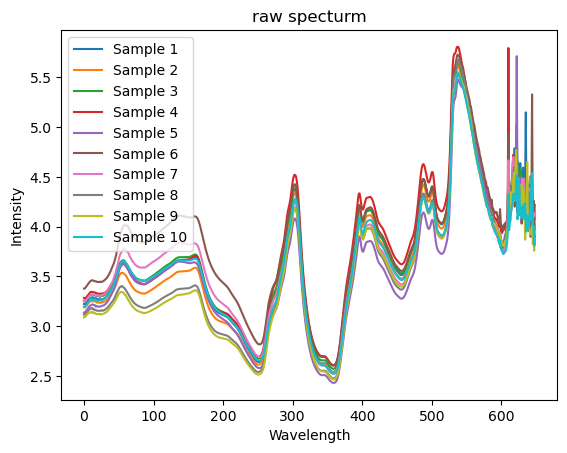

In [34]:


data, label = LoadNirtest('Rgs')
plotspc(data, "raw specturm")

In [44]:
import numpy as np
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy
import pandas as pd
import pywt

# ref1: 湖南示范大学同学实列，并做了部分修改
# ref2: https://blog.csdn.net/qq2512446791

# Max-min normalization
def MMS(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after MinMaxScaler :(n_samples, n_features)
       """
    return MinMaxScaler().fit_transform(data)


# standardization
def SS(data):
    """
        :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after StandScaler :(n_samples, n_features)
       """
    return StandardScaler().fit_transform(data)


# mean value centrality
def CT(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after MeanScaler :(n_samples, n_features)
       """
    for i in range(data.shape[0]):
        MEAN = np.mean(data[i])
        data[i] = data[i] - MEAN
    return data


#standard normal transform (math.)
def SNV(data):
    """
        :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after SNV :(n_samples, n_features)
    """
    m = data.shape[0]
    n = data.shape[1]
    print(m, n)  #
    # 求标准差
    data_std = np.std(data, axis=1)  # 每条光谱的标准差
    # 求平均值
    data_average = np.mean(data, axis=1)  # 每条光谱的平均值
    # SNV计算
    data_snv = [[((data[i][j] - data_average[i]) / data_std[i]) for j in range(n)] for i in range(m)]
    return  np.array(data_snv)



# 
def MA(data, WSZ=11):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :param WSZ: int
       :return: data after MA :(n_samples, n_features)
    """

    for i in range(data.shape[0]):
        out0 = np.convolve(data[i], np.ones(WSZ, dtype=int), 'valid') / WSZ # WSZ是窗口宽度，是奇数
        r = np.arange(1, WSZ - 1, 2)
        start = np.cumsum(data[i, :WSZ - 1])[::2] / r
        stop = (np.cumsum(data[i, :-WSZ:-1])[::2] / r)[::-1]
        data[i] = np.concatenate((start, out0, stop))
    return data


# Savitzky-Golay
def SG(data, w=11, p=2):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :param w: int
       :param p: int
       :return: data after SG :(n_samples, n_features)
    """
    return signal.savgol_filter(data, w, p)


# First Derivative
def D1(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after First derivative :(n_samples, n_features)
    """
    n, p = data.shape
    Di = np.ones((n, p - 1))
    for i in range(n):
        Di[i] = np.diff(data[i])
    return Di


# Second Dericative
def D2(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after second derivative :(n_samples, n_features)
    """
    data = deepcopy(data)
    if isinstance(data, pd.DataFrame):
        data = data.values
    temp2 = (pd.DataFrame(data)).diff(axis=1)
    temp3 = np.delete(temp2.values, 0, axis=1)
    temp4 = (pd.DataFrame(temp3)).diff(axis=1)
    spec_D2 = np.delete(temp4.values, 0, axis=1)
    return spec_D2


# Trend correction (DT)
def DT(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after DT :(n_samples, n_features)
    """
    lenth = data.shape[1]
    x = np.asarray(range(lenth), dtype=np.float32)
    out = np.array(data)
    l = LinearRegression()
    for i in range(out.shape[0]):
        l.fit(x.reshape(-1, 1), out[i].reshape(-1, 1))
        k = l.coef_
        b = l.intercept_
        for j in range(out.shape[1]):
            out[i][j] = out[i][j] - (j * k + b)

    return out


# multiple scattering correction
def MSC(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after MSC :(n_samples, n_features)
    """
    n, p = data.shape
    msc = np.ones((n, p))

    for j in range(n):
        mean = np.mean(data, axis=0)

    # linear fitting
    for i in range(n):
        y = data[i, :]
        l = LinearRegression()
        l.fit(mean.reshape(-1, 1), y.reshape(-1, 1))
        k = l.coef_
        b = l.intercept_
        msc[i, :] = (y - b) / k
    return msc

#wavelet transform (math.)
def wave(data):
    """
       :param data: raw spectrum data, shape (n_samples, n_features)
       :return: data after wave :(n_samples, n_features)
    """
    data = deepcopy(data)
    if isinstance(data, pd.DataFrame):
        data = data.values
    def wave_(data):
        w = pywt.Wavelet('db8')  # 选用Daubechies8小波
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, 'db8', level=maxlev)
        threshold = 0.04
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
        datarec = pywt.waverec(coeffs, 'db8')
        return datarec

    tmp = None
    for i in range(data.shape[0]):
        if (i == 0):
            tmp = wave_(data[i])
        else:
            tmp = np.vstack((tmp, wave_(data[i])))

    return tmp

def Preprocessing(method, data):

    if method == "None":
        data = data
    elif method == 'MMS':
        data = MMS(data)
    elif method == 'SS':
        data = SS(data)
    elif method == 'CT':
        data = CT(data)
    elif method == 'SNV':
        data = SNV(data)
    elif method == 'MA':
        data = MA(data)
    elif method == 'SG':
        data = SG(data)
    elif method == 'MSC':
        data = MSC(data)
    elif method == 'D1':
        data = D1(data)
    elif method == 'D2':
        data = D2(data)
    elif method == 'DT':
        data = DT(data)
    elif method == 'WVAE':
        data = wave(data)
    else:
        print("no this method of preprocessing!")

    return data

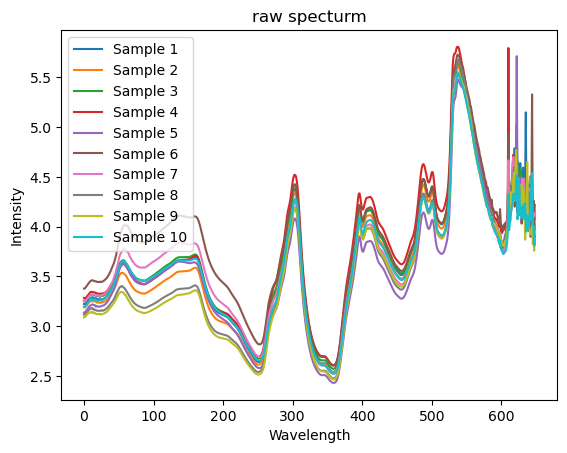

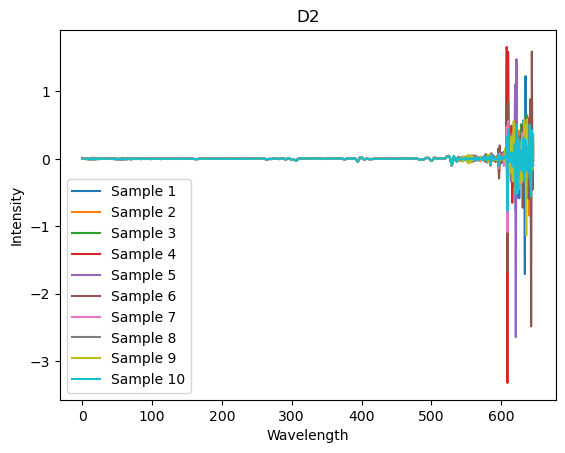

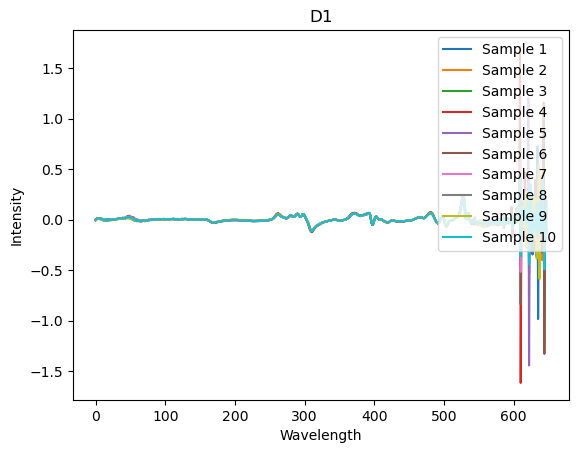

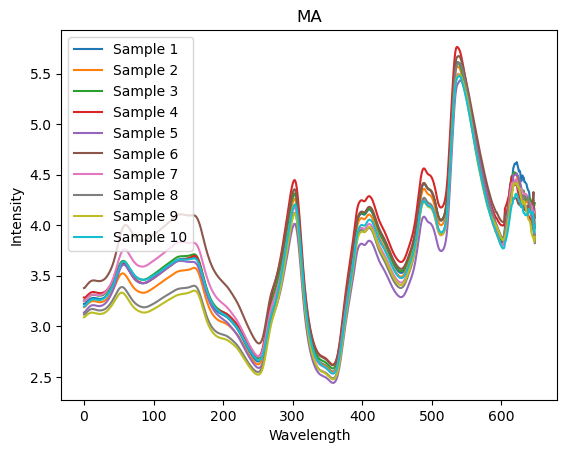

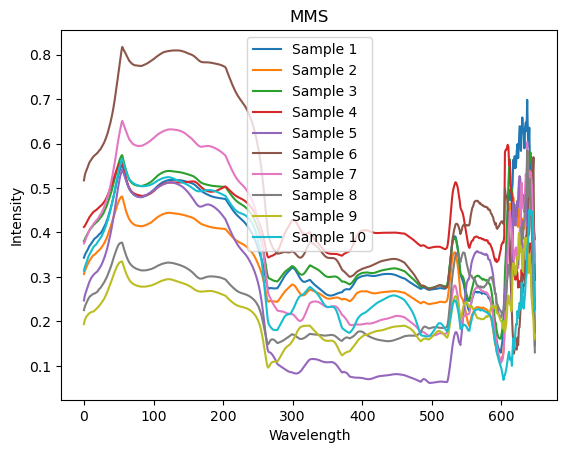

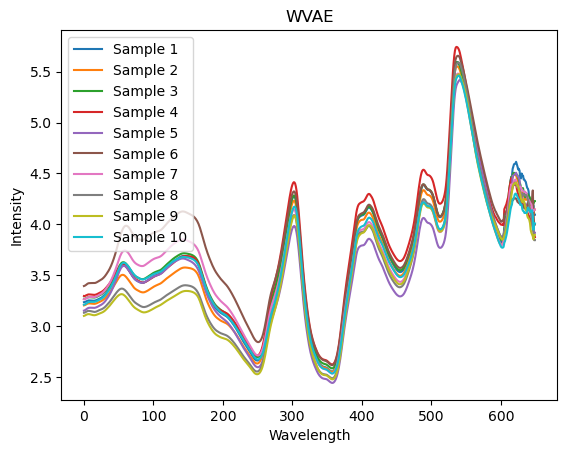

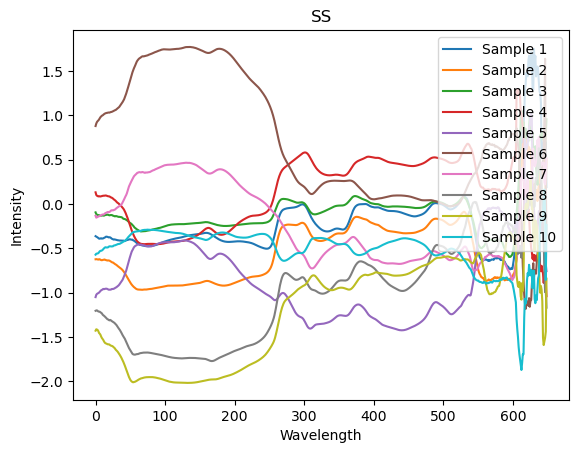

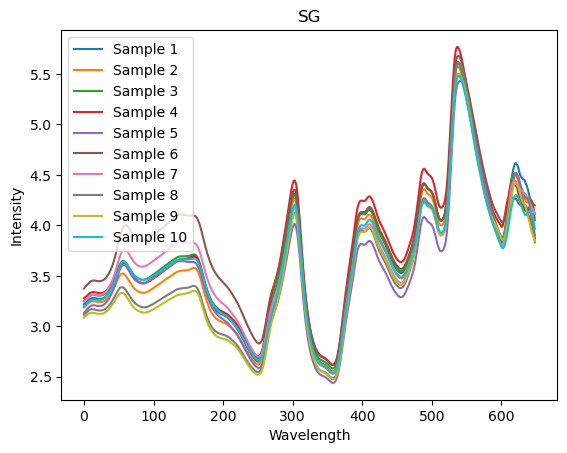

In [48]:
#Visualization of data
data, label = LoadNirtest('Rgs')
plotspc(data, "raw specturm")
#光谱预处理并可视化
method = "D2"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "D1"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "MA"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "MMS"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "WVAE"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "SS"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "SG"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)
method = "SNV"
Preprocessingdata = Preprocessing(method, data)
plotspc(Preprocessingdata, method)


